# 1.0 Load and inspect the fragility curve database

In [118]:
%reset

import os
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt

from pathlib import Path
from scipy.stats import norm
from matplotlib import gridspec
from scipy.optimize import curve_fit
from matplotlib.font_manager import FontProperties as fp

%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

In [119]:

# import the database based on PGA
df_pga = pd.read_excel("fragility_curve_database_pga.xlsx")

# import the database based on SA(T1)
df_sa = pd.read_excel("fragility_curve_database_sat1.xlsx")

In [120]:
# Convert the fragility curves from SA(T1) to PGA by using the EC8 design
# response spectrum
# Functions for creating a new column in dataframe for the converted median values
T_params = {"A":{"S":1.00, "TB":0.15, "TC":0.4, "TD":2.0},
            "B":{"S":1.20, "TB":0.15, "TC":0.5, "TD":2.0},
            "C":{"S":1.15, "TB":0.20, "TC":0.6, "TD":2.0},
            "D":{"S":1.35, "TB":0.20, "TC":0.8, "TD":2.0},
            "E":{"S":1.40, "TB":0.15, "TC":0.5, "TD":2.0}}


def backcalculate_pga(sa_t1, T, soil_class):
    
    eta = 1
    Tb = T_params[soil_class]["TB"]
    Tc = T_params[soil_class]["TC"]
    Td = T_params[soil_class]["TD"]
    
    if 0 <= T <= Tb:
        ag_des = sa_t1 / (1 + (T / Tb) * (eta * 2.5 - 1))
    elif Tb <= T <= Tc:
        ag_des = sa_t1 / (eta * 2.5)
    elif Tc <= T <= Td:
        ag_des = sa_t1 / (eta * 2.5 * Tc / T)
    elif Td <= T <= 4:
        ag_des = sa_t1 / (eta * 2.5 * (Tc * Td / T ** 2))
        
    return ag_des
    
    
def backcalculate_pga_series(sa_t1, T, soil_class):
    
    index = sa_t1.index
    ag_des = [backcalculate_pga(sa_i, Ti, sc_i) 
              for sa_i, Ti, sc_i in zip(sa_t1, T, soil_class)]
    
    return pd.Series(ag_des, index)
    
df_sa["med_c_PGA"] = backcalculate_pga_series(df_sa['med_c_SA'], 
                                              df_sa['T1'], 
                                              df_sa['soilclass'])


In [121]:
# concatenate the dataframes and clean up a bit
df = pd.concat([df_pga, df_sa])
df['beta_c_PGA'] = df['beta_c_PGA'].fillna(0)
df['beta_c_SA'] = df['beta_c_SA'].fillna(0)
df["beta_c_PGA"] = df[["beta_c_PGA", "beta_c_SA"]].max(axis=1)
df = df.drop(columns=["med_yield", "beta_yield", "notes", "code", "soilclass", "T1", "med_c_SA", "beta_c_SA"])
# remove curves from studies of Papailia et al. and Antoniou as these are not for collapse
df = df[(df["Author"] != "Papailia et al.")]
df = df[(df["Author"] != "Antoniou")]

In [122]:
# separating into different materials
rc = df[df["Material"] == "RC"]
st = df[df["Material"] == "Steel"]
df.columns

Index(['Author', 'Reference Number', 'Material', 'Typology', 'Ductility',
       'Floors', 'Method', 'PGA_des', 'med_c_PGA', 'beta_c_PGA', 'origin_IM',
       'Unnamed: 15', 'Unnamed: 16'],
      dtype='object')

In [123]:
# separate into RC moment resisting frames and Wall/Dual systems
rc_mrfs = rc[(rc["Typology"] == "MRF")]
n_mrfs = rc_mrfs.shape[0]

rc_wds = rc[(rc["Typology"] != "MRF")]
n_wds = rc_wds.shape[0]

print(f"Number of RC-MRF system fragility curves: {n_mrfs}")
print(f"Number of RC-Dual system fragility curves: {n_wds}")

Number of RC-MRF system fragility curves: 136
Number of RC-Dual system fragility curves: 21


In [124]:
# separate into steel moment resisting frames
s_mrfs = st[(st["Typology"] == "MRF")]
n_smrfs = s_mrfs.shape[0]

print(f"Number of Steel-MRF system fragility curves: {n_smrfs}")

Number of Steel-MRF system fragility curves: 33


## 2.0 Visualising the Databases

In [125]:
# Constants and functions for plotting
figure_folder = Path('C:/niccl/Documents/risiko-basierte-erdbebenkarte/Bearbeitung/new_figures')
colours = {1:'k', 2:'b', 3:'r', 4:'g', 5:'darkorange', 6:'c',
           7:'m', 8:'k', 9:'y', 10:'lawngreen'} 

axis_title_font = {'family': 'serif',
                    'color':  'black',
                    'weight': 'normal',
                    'size': 10,
                    }

annotation_font = fp(family='serif', style='normal', size=9,
                          weight='normal', stretch='normal')

axis_ticklabel_font = fp(family='serif', style='normal', size=9,
                          weight='normal', stretch='normal')

legend_font = fp(family='serif', style='normal', size=7,
                          weight='normal', stretch='normal')

file_type = "pdf"

# create a basic figure
def basic_1x1_figure():
    fig = plt.figure(figsize=(3.2, 3))
    gs = gridspec.GridSpec(1, 1, width_ratios=[1],
                       wspace=0.2, hspace=0.2, top=0.98, bottom=0.15, left=0.15, right=0.99)
    ax = fig.add_subplot(gs[0,0])
    return ax
    
# basic formating of the axes etc    
def basic_1x1_format_and_save(ax, figure_name):
    for label in ax.get_yticklabels() :
        label.set_fontproperties(axis_ticklabel_font)
    for label in ax.get_xticklabels() :
        label.set_fontproperties(axis_ticklabel_font)

    ax.legend(prop=legend_font, loc=2)
    ax.tick_params('both', direction='in', which='both', pad=6)

    plt.savefig(figure_folder / figure_name, dpi=800)
    plt.savefig(figure_folder / (figure_name + "." + file_type), dpi=800, format=file_type)
    return
    
# create a basic 1x2 figure
def basic_1x2_figure():
    fig = plt.figure(figsize=(6.4,3.2))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1],
                       wspace=0.2, hspace=0.2, top=0.98, bottom=0.25, left=0.1, right=0.99)
    ax1 = fig.add_subplot(gs[0,0])
    ax2 = fig.add_subplot(gs[0,1], sharey=ax1, sharex=ax1)
    return ax1, ax2

# basic formation of the axes
def basic_1x2_format_and_save(ax1, ax2, figure_name, legend_parts=None, legend_ax=None):
    for label in ax1.get_yticklabels() :
        label.set_fontproperties(axis_ticklabel_font)
        
    for ax in [ax1, ax2]:
        for label in ax1.get_xticklabels() :
            label.set_fontproperties(axis_ticklabel_font)
        
        if legend_parts == None:    
            ax.legend(prop=legend_font, loc=2)
        
        ax.tick_params('both', direction='in', which='both', pad=6)
        
    for label in ax2.get_xticklabels() :
        label.set_fontproperties(axis_ticklabel_font)
        
    
    if legend_parts != None:
        legend_ax.legend(*legend_parts, prop=legend_font)

    plt.setp(ax2.get_yticklabels(), visible=False)
    
    plt.annotate("(a)", (0.29,0.06), xycoords="figure fraction", fontproperties= annotation_font)
    plt.annotate("(b)", (0.78,0.06), xycoords="figure fraction", fontproperties= annotation_font)

    plt.savefig(figure_folder / figure_name, dpi=800)
    plt.savefig(figure_folder / (figure_name + "." + file_type), dpi=800, format=file_type)
    
    return    
    

### 2.1 - The complete database

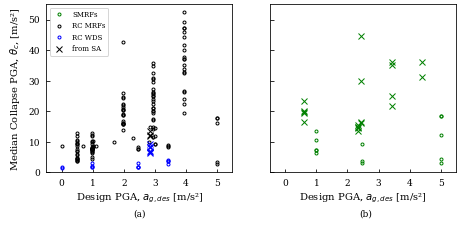

In [126]:
# Plotting the Whole Database
figure_name = "Fig1_databank-summary"#

[ax1, ax2] = basic_1x2_figure()

# RC Structures
# df[(df["Author"] != "Antoniou")]
ax1.plot(rc_mrfs[rc_mrfs["origin_IM"] == "PGA"].PGA_des, rc_mrfs[rc_mrfs["origin_IM"] == "PGA"].med_c_PGA, ls="", marker=".", mec="k", mfc="none",  label="RC MRFs")
ax1.plot(rc_wds[rc_wds["origin_IM"] == "PGA"].PGA_des,rc_wds[rc_wds["origin_IM"] == "PGA"].med_c_PGA, ls="", marker=".", mec="b", mfc="none",  label="RC WDS")
ax1.plot(rc_mrfs[rc_mrfs["origin_IM"] == "SA"].PGA_des, rc_mrfs[rc_mrfs["origin_IM"] == "SA"].med_c_PGA, ls="", marker="x", mec="k", mfc="none", label="from SA")
ax1.plot(rc_wds[rc_wds["origin_IM"] == "SA"].PGA_des, rc_wds[rc_wds["origin_IM"] == "SA"].med_c_PGA, ls="", marker="x", mec="b", mfc="none")
ax1.set_xlabel(r'Design PGA, $a_{g,des}$ [m/s²]', fontdict=axis_title_font)
ax1.set_ylabel(r'Median Collapse PGA, $\theta_{c}$, [m/s²]', fontdict=axis_title_font, labelpad=6)
ax1.set_xlim(-0.5,5.5)
ax1.set_ylim(0)

rc_handles, rc_labels = ax1.get_legend_handles_labels()

# Steel Structures
ax2.plot(st[st["origin_IM"] == "PGA"].PGA_des, st[st["origin_IM"] == "PGA"].med_c_PGA, ls="", marker=".", mec="g", mfc="none",  label="SMRFs")
ax2.plot(st[st["origin_IM"] == "SA"].PGA_des, st[st["origin_IM"] == "SA"].med_c_PGA, ls="", marker="x", mec="g", mfc="none")
ax2.set_xlabel(r'Design PGA, $a_{g,des}$ [m/s²]', fontdict=axis_title_font)
st_handles, st_labels = ax2.get_legend_handles_labels()

handles = st_handles + rc_handles
labels = st_labels + rc_labels

basic_1x2_format_and_save(ax1, ax2, figure_name, legend_parts=[handles, labels], legend_ax=ax1)

### 2.2 - RC Moment Resisting Frames

##### 2.2.1 - RC-MRF-M and RC-MRF-R

number of fragility curves from Martins et al. : 100
number of fragility curves from the rest : 36


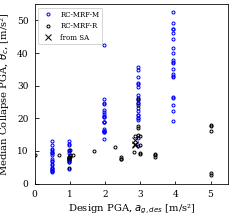

In [127]:
# Plotting the RC database showing difference between the curves from
# Martins et al. and the remaining studies
figure_name = "Fig2_rc_mrf_comparison"#

# divide the mrf database
rc_mrf_m = rc_mrfs[rc_mrfs["Author"] == "Martins et al."]
rc_mrf_r = rc_mrfs[rc_mrfs["Author"] != "Martins et al."]

ax1 = basic_1x1_figure()

ax1.plot(rc_mrf_m.PGA_des, rc_mrf_m.med_c_PGA, ls="", marker=".", mec="b", mfc="none",  label="RC-MRF-M")
# ax1.plot(rc_mrf_r.PGA_des, rc_mrf_r.med_c_PGA, ls="", marker=".", mec="k", mfc="none",  label="RC-MRF-R")
ax1.plot(rc_mrf_r[rc_mrf_r["origin_IM"] == "PGA"].PGA_des, rc_mrf_r[rc_mrf_r["origin_IM"] == "PGA"].med_c_PGA, ls="", marker=".", mec="k", mfc="none",  label="RC-MRF-R")
ax1.plot(rc_mrf_r[rc_mrf_r["origin_IM"] == "SA"].PGA_des, rc_mrf_r[rc_mrf_r["origin_IM"] == "SA"].med_c_PGA, ls="", marker="x", mec="k", mfc="none", label="from SA")
ax1.set_xlabel(r'Design PGA, $a_{g,des}$ [m/s²]', fontdict=axis_title_font)
ax1.set_ylabel(r'Median Collapse PGA, $\theta_{c}$, [m/s²]', fontdict=axis_title_font, labelpad=6)
ax1.set_xlim(0,5.5)
ax1.set_ylim(0)

basic_1x1_format_and_save(ax1, figure_name)

n_martins = rc_mrf_m.shape[0]
n_rest = rc_mrf_r.shape[0]

print(f"number of fragility curves from Martins et al. : {n_martins}")
print(f"number of fragility curves from the rest : {n_rest}")

#### 2.2.1 - RC-MRF-R Disaggregation

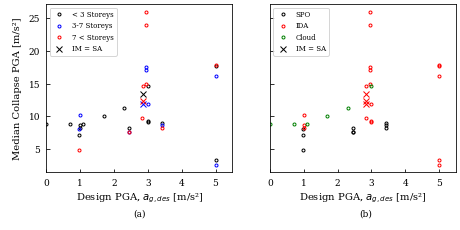

In [128]:
# new 1x2 plot for RC MRFs only
figure_name = "Fig3_rc-mrf-r_disaggregation"

# Stories
rc_mrf_r.Floors.unique()
rc_mrf_r_k = rc_mrf_r[rc_mrf_r["Floors"] <= 3]
rc_mrf_r_m = rc_mrf_r[(rc_mrf_r["Floors"] > 3) & (rc_mrf_r["Floors"] <= 7)]
rc_mrf_r_h = rc_mrf_r[rc_mrf_r["Floors"] > 7]

rc_mrf_r.Method.unique()
rc_mrf_r_cov = rc_mrf_r[rc_mrf_r["Method"] == "SPO"]
rc_mrf_r_ida = rc_mrf_r[rc_mrf_r["Method"] == "IDA"]
rc_mrf_r_cloud = rc_mrf_r[rc_mrf_r["Method"] == "Cloud"]

[ax1, ax2] = basic_1x2_figure()

# Floors
# ax1.plot(rc_mrf_r_k.PGA_des, rc_mrf_r_k.med_c_PGA, ls="", marker=".", mec="k", mfc="none",  label="< 3 Storeys")
# ax1.plot(rc_mrf_r_m.PGA_des, rc_mrf_r_m.med_c_PGA, ls="", marker=".", mec="b", mfc="none",  label="3-7 Storeys")
# ax1.plot(rc_mrf_r_h.PGA_des, rc_mrf_r_h.med_c_PGA, ls="", marker=".", mec="r", mfc="none",  label="7 < Storeys")

ax1.plot(rc_mrf_r_k[rc_mrf_r_k["origin_IM"] == "PGA"].PGA_des, rc_mrf_r_k[rc_mrf_r_k["origin_IM"] == "PGA"].med_c_PGA, ls="", marker=".", mec="k", mfc="none",  label="< 3 Storeys")
ax1.plot(rc_mrf_r_m[rc_mrf_r_m["origin_IM"] == "PGA"].PGA_des, rc_mrf_r_m[rc_mrf_r_m["origin_IM"] == "PGA"].med_c_PGA, ls="", marker=".", mec="b", mfc="none",  label="3-7 Storeys")
ax1.plot(rc_mrf_r_h[rc_mrf_r_h["origin_IM"] == "PGA"].PGA_des, rc_mrf_r_h[rc_mrf_r_h["origin_IM"] == "PGA"].med_c_PGA, ls="", marker=".", mec="r", mfc="none",  label="7 < Storeys")

ax1.plot(rc_mrf_r_k[rc_mrf_r_k["origin_IM"] == "SA"].PGA_des, rc_mrf_r_k[rc_mrf_r_k["origin_IM"] == "SA"].med_c_PGA, ls="", marker="x", mec="k", mfc="none",  label="IM = SA")
ax1.plot(rc_mrf_r_m[rc_mrf_r_m["origin_IM"] == "SA"].PGA_des, rc_mrf_r_m[rc_mrf_r_m["origin_IM"] == "SA"].med_c_PGA, ls="", marker="x", mec="b", mfc="none")
ax1.plot(rc_mrf_r_h[rc_mrf_r_h["origin_IM"] == "SA"].PGA_des, rc_mrf_r_h[rc_mrf_r_h["origin_IM"] == "SA"].med_c_PGA, ls="", marker="x", mec="r", mfc="none")

ax1.set_xlim(0,5.5)
# ax1.set_ylim(0, 15)
ax1.set_xticks([0, 1.0, 2.0, 3.0, 4.0, 5.0])
# ax1.set_yticks([0, 5, 10, 15])
ax1.set_ylabel('Median Collapse PGA [m/s²]', fontdict=axis_title_font, labelpad=6)
ax1.set_xlabel(r'Design PGA, $a_{g,des}$ [m/s²]', fontdict=axis_title_font)

# Analysis Method
# ax2.plot(rc_mrf_r_cov.PGA_des, rc_mrf_r_cov.med_c_PGA, ls="", marker=".", mec="k", mfc="none",  label="SPO")
# ax2.plot(rc_mrf_r_ida.PGA_des, rc_mrf_r_ida.med_c_PGA, ls="", marker=".", mec="r", mfc="none",  label="IDA")
# ax2.plot(rc_mrf_r_cloud.PGA_des, rc_mrf_r_cloud.med_c_PGA, ls="", marker=".", mec="g", mfc="none",  label="Cloud")

ax2.plot(rc_mrf_r_cov[rc_mrf_r_cov["origin_IM"] == "PGA"].PGA_des, rc_mrf_r_cov[rc_mrf_r_cov["origin_IM"] == "PGA"].med_c_PGA, ls="", marker=".", mec="k", mfc="none",  label="SPO")
ax2.plot(rc_mrf_r_ida[rc_mrf_r_ida["origin_IM"] == "PGA"].PGA_des, rc_mrf_r_ida[rc_mrf_r_ida["origin_IM"] == "PGA"].med_c_PGA, ls="", marker=".", mec="r", mfc="none",  label="IDA")
ax2.plot(rc_mrf_r_cloud[rc_mrf_r_cloud["origin_IM"] == "PGA"].PGA_des, rc_mrf_r_cloud[rc_mrf_r_cloud["origin_IM"] == "PGA"].med_c_PGA, ls="", marker=".", mec="g", mfc="none",  label="Cloud")

ax2.plot(rc_mrf_r_cov[rc_mrf_r_cov["origin_IM"] == "SA"].PGA_des, rc_mrf_r_cov[rc_mrf_r_cov["origin_IM"] == "SA"].med_c_PGA, ls="", marker="x", mec="k", mfc="none",  label="IM = SA")
ax2.plot(rc_mrf_r_ida[rc_mrf_r_ida["origin_IM"] == "SA"].PGA_des, rc_mrf_r_ida[rc_mrf_r_ida["origin_IM"] == "SA"].med_c_PGA, ls="", marker="x", mec="r", mfc="none")
ax2.plot(rc_mrf_r_cloud[rc_mrf_r_cloud["origin_IM"] == "SA"].PGA_des, rc_mrf_r_cloud[rc_mrf_r_cloud["origin_IM"] == "SA"].med_c_PGA, ls="", marker="x", mec="g", mfc="none")


ax2.set_xlabel(r'Design PGA, $a_{g,des}$ [m/s²]', fontdict=axis_title_font)

basic_1x2_format_and_save(ax1, ax2, figure_name)

#### 2.2.3 - RC-MRF-M Disaggregation

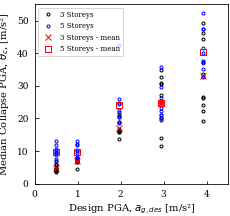

In [129]:
# Plotting the RC database showing difference between Martins et al. and the rest
figure_name = "Fig4_rc-mrf-m_disaggregation"#

# Stories
rc_mrf_m_3 = rc_mrf_m[rc_mrf_m["Floors"] == 3]
rc_mrf_m_5 = rc_mrf_m[rc_mrf_m["Floors"] == 5]

# Mean and Median values for the 3 and 5 storie buildings
rc_mrf_m_3_mean = [rc_mrf_m_3[(rc_mrf_m_3.PGA_des == pga)]["med_c_PGA"].mean() for pga in rc_mrf_m_3.PGA_des.unique()]
rc_mrf_m_5_mean = [rc_mrf_m_5[(rc_mrf_m_5.PGA_des == pga)]["med_c_PGA"].mean() for pga in rc_mrf_m_5.PGA_des.unique()]

# plotting
ax1 = basic_1x1_figure()

ax1.plot(rc_mrf_m_3.PGA_des, rc_mrf_m_3.med_c_PGA, ls="", marker=".", mec="k", mfc="none",  label="3 Storeys")
ax1.plot(rc_mrf_m_5.PGA_des, rc_mrf_m_5.med_c_PGA, ls="", marker=".", mec="b", mfc="none",  label="5 Storeys")
ax1.plot(rc_mrf_m_3.PGA_des.unique(), rc_mrf_m_3_mean, ls="", marker="x", mec="r", mfc="none",  label="3 Storeys - mean")
ax1.plot(rc_mrf_m_5.PGA_des.unique(), rc_mrf_m_5_mean, ls="", marker="s", mec="r", mfc="none",  label="5 Storeys - mean")

ax1.set_ylabel(r'Median Collapse PGA, $\theta_{c}$, [m/s²]', fontdict=axis_title_font, labelpad=6)
ax1.set_xlabel(r'Design PGA, $a_{g,des}$ [m/s²]', fontdict=axis_title_font)

ax1.set_xlim(0, 4.5)
ax1.set_ylim(0, 55)

basic_1x1_format_and_save(ax1, figure_name)

### 2.3 Steel Database

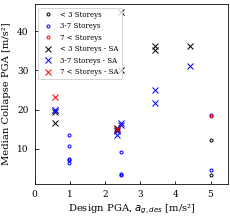

In [130]:
# new 1x2 plot for RC MRFs only
figure_name = "Fig3a_smrf_disaggregation"

# Stories
st.Floors.unique()
st_k = st[st["Floors"] <= 3]
st_m = st[(st["Floors"] > 3) & (st["Floors"] <= 7)]
st_h = st[st["Floors"] > 7]

ax1 = basic_1x1_figure()

# Floors
ax1.plot(st_k[st_k["origin_IM"] == "PGA"].PGA_des, st_k[st_k["origin_IM"] == "PGA"].med_c_PGA, ls="", marker=".", mec="k", mfc="none",  label="< 3 Storeys")
ax1.plot(st_m[st_m["origin_IM"] == "PGA"].PGA_des, st_m[st_m["origin_IM"] == "PGA"].med_c_PGA, ls="", marker=".", mec="b", mfc="none",  label="3-7 Storeys")
ax1.plot(st_h[st_h["origin_IM"] == "PGA"].PGA_des, st_h[st_h["origin_IM"] == "PGA"].med_c_PGA, ls="", marker=".", mec="r", mfc="none",  label="7 < Storeys")

ax1.plot(st_k[st_k["origin_IM"] == "SA"].PGA_des, st_k[st_k["origin_IM"] == "SA"].med_c_PGA, ls="", marker="x", mec="k", mfc="none",  label="< 3 Storeys - SA")
ax1.plot(st_m[st_m["origin_IM"] == "SA"].PGA_des, st_m[st_m["origin_IM"] == "SA"].med_c_PGA, ls="", marker="x", mec="b", mfc="none",  label="3-7 Storeys - SA")
ax1.plot(st_h[st_h["origin_IM"] == "SA"].PGA_des, st_h[st_h["origin_IM"] == "SA"].med_c_PGA, ls="", marker="x", mec="r", mfc="none",  label="7 < Storeys - SA")

ax1.set_xlim(0,5.5)
# ax1.set_ylim(0, 15)
ax1.set_xticks([0, 1.0, 2.0, 3.0, 4.0, 5.0])
# ax1.set_yticks([0, 5, 10, 15])
ax1.set_ylabel('Median Collapse PGA [m/s²]', fontdict=axis_title_font, labelpad=6)
ax1.set_xlabel(r'Design PGA, $a_{g,des}$ [m/s²]', fontdict=axis_title_font)

basic_1x1_format_and_save(ax1, figure_name)

### 2.4 - Final Typology Databases

In [131]:
# filtering of removal of Saruddin as values are unrealistically low
RC_MRF_R = rc_mrf_r[(rc_mrf_r["Author"] != "Saruddin et al.")]
RC_MRF_M = rc_mrf_m
RC_WDS = rc_wds.drop(index=[126, 127, 129])
S_MRF = st[st["Author"] != "Saruddin et al."]

## 3.0 - Best Fit for Median Collapse PGA

In [132]:
# linear function for fitting
def linear_fn(x, m, c):
    return m*x + c

# powerlaw fit on the mu/design pga
def power_fn(x, a, b):
    return a * x ** (1 + b)
    
# powerlaw fit on the mu/design pga
def power2_fn(x, a, b):
    return a * x ** b

# function to return the fit and the r2 value   
def my_curve_fit(fn, x, y):
    params, cov = curve_fit(fn, x, y)
    residuals = y - fn(x, *params)
    r_squared = 1 - (np.sum(residuals**2) / np.sum((y - np.mean(y))**2))
    return params, cov, residuals, r_squared
    
# pgas for plotting best fit    
PGAS = np.linspace(0.0, 5)

def fitting_curve(in_db, fn=linear_fn, tag=""):
    if tag == "":
        tag = "med_c_PGA"
    res = my_curve_fit(fn, in_db.PGA_des, in_db[tag])
    m = res[0][0]
    c = res[0][1]
    print(f"\nResults of fitting data with a Linear Function:")
    print (f"m = {m}")
    print (f"c = {c}")
    print (f"r2 = {res[3]}")
    bf = fn(PGAS, m, c)
    return m, c, res, bf
    
def plot_fit(ax, in_db, m, c, bf, label):
    ax1.plot(in_db.PGA_des, in_db.med_c_PGA, ls="", marker="o", mec="0.6", mfc="none", label=label)
    ax1.plot(PGAS, bf, ls="-", color="k", lw=1.25, label="Linear best fit")

    ax1.set_ylabel(r'Median Collapse PGA, $\theta_{c}$, [m/s²]', fontdict=axis_title_font, labelpad=6)
    ax1.set_xlabel('Design PGA [m/s²]', fontdict=axis_title_font)
    
    ax1.set_xlim(0, 5.5)
    
    plt.annotate(f"y = {m:.3f}x + {c:.3f}", (0.6,0.2), xycoords="figure fraction", fontproperties= annotation_font)
    
    return
    
def dispersion(m, c, in_db):
    # finds the dispersion of the RV around the mean (best fit line)
    # Assumes lognormal and homoscedastic error
    err = [np.log(m*row["PGA_des"] + (c)) - np.log(row["med_c_PGA"]) for idx, row in in_db.iterrows()]
    n = len(err)
    plt.figure()
    plt.plot(in_db["PGA_des"], err, "o", mec="k")

    err = np.array(err)
    beta = np.sqrt((1 / (n-1)) * sum(err ** 2))
    print(f"Dispersion of median values: {beta}")
    
    return beta



### 3.1 - RC-MRF-R

#### 3.1.1 - Linear fit


Results of fitting data with a Linear Function:
m = 2.1108588601805853
c = 6.54265458627492
r2 = 0.28869054610229017


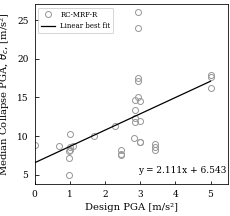

In [133]:
# fit curve
input_db = RC_MRF_R
label = "RC-MRF-R"
[rc_mrf_r_m, rc_mrf_r_c, res, rc_mrf_r_bf] = fitting_curve(input_db)

# Create plot
figure_name = "rc-mrf-r_best-fit"

ax1 = basic_1x1_figure()
plot_fit(ax1, input_db, rc_mrf_r_m, rc_mrf_r_c, rc_mrf_r_bf, label)

basic_1x1_format_and_save(ax1, figure_name)

Dispersion of median values: 0.3072109393935286


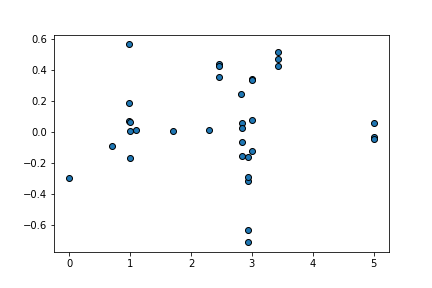

In [134]:
# characterising the variance around the regression curve
rc_mrf_r_beta_theta = dispersion(rc_mrf_r_m, rc_mrf_r_c, input_db)

Linear fit only considering the dynamic analysis methods


Results of fitting data with a Linear Function:
m = 2.167400805714511
c = 7.712875455747752
r2 = 0.3427815999079097


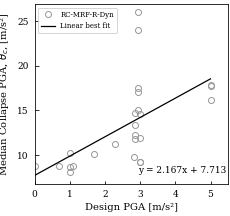

In [135]:
# fit curve
input_db = RC_MRF_R[(RC_MRF_R["Method"] != "SPO")]
label = "RC-MRF-R-Dyn"
[rc_mrf_r_dyn_m, rc_mrf_r_dyn_c, res, rc_mrf_r_dynbf] = fitting_curve(input_db)

# Create plot
figure_name = "rc-mrf-r_best-fit"

ax1 = basic_1x1_figure()
plot_fit(ax1, input_db, rc_mrf_r_dyn_m, rc_mrf_r_dyn_c, rc_mrf_r_dynbf, label)

basic_1x1_format_and_save(ax1, figure_name)

Linear fit only considering the static analysis methods


Results of fitting data with a Linear Function:
m = 0.7842105261063964
c = 5.922142105702042
r2 = 0.49095532950022136


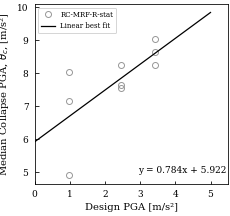

In [136]:
# fit curve
input_db = RC_MRF_R[(RC_MRF_R["Method"] == "SPO")]
label = "RC-MRF-R-stat"
[rc_mrf_r_stat_m, rc_mrf_r_stat_c, res, rc_mrf_r_statbf] = fitting_curve(input_db)

# Create plot
figure_name = "rc-mrf-r_best-fit"

ax1 = basic_1x1_figure()
plot_fit(ax1, input_db, rc_mrf_r_stat_m, rc_mrf_r_stat_c, rc_mrf_r_statbf, label)

basic_1x1_format_and_save(ax1, figure_name)

Linear fit only considering PGA


Results of fitting data with a Linear Function:
m = 2.1118771494724005
c = 6.544539113885744
r2 = 0.2878433084666542


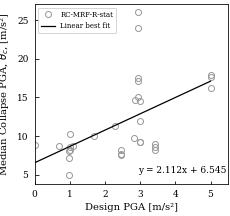

In [137]:
# fit curve
input_db = RC_MRF_R[(RC_MRF_R["origin_IM"] == "PGA")]
label = "RC-MRF-R-stat"
[rc_mrf_r_m, rc_mrf_r_c, res, rc_mrf_r_pgabf] = fitting_curve(input_db)

# Create plot
figure_name = "rc-mrf-r_best-fit"

ax1 = basic_1x1_figure()
plot_fit(ax1, input_db, rc_mrf_r_m, rc_mrf_r_c, rc_mrf_r_pgabf, label)

basic_1x1_format_and_save(ax1, figure_name)

#### 3.1.2 Power fit on mu/PGA_des


Results of fitting MRF Final Data with a Power Function:
a = 8.374457731196244
b = -0.6108153314396292
r2 = 0.5956188332676821


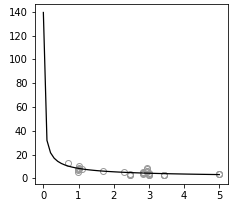

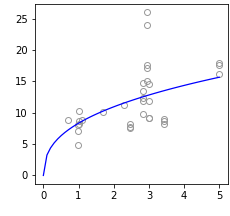

In [138]:
dfxx = RC_MRF_R.copy()
dfxx["mu"] = dfxx["med_c_PGA"] / dfxx["PGA_des"]
dfxx = dfxx[(dfxx["mu"] != np.inf)]
mrf_final_res = my_curve_fit(power2_fn, dfxx.PGA_des, dfxx.mu)
a_mrf = mrf_final_res[0][0]
b_mrf = mrf_final_res[0][1]
print(f"\nResults of fitting MRF Final Data with a Power Function:")
print (f"a = {a_mrf}")
print (f"b = {b_mrf}")
print (f"r2 = {mrf_final_res[3]}")
pgas = np.linspace(0.01, 5)
dfxx_bf = power2_fn(pgas, mrf_final_res[0][0], mrf_final_res[0][1])
ax1 = basic_1x1_figure()
ax1.plot(dfxx.PGA_des, dfxx.mu, ls="", marker="o", mec="0.6", mfc="none")
ax1.plot(PGAS, dfxx_bf, ls="-", color="k", lw=1.25, label="Power2 best fit")

dfxx_bf22 = dfxx_bf * PGAS
ax1 = basic_1x1_figure()
ax1.plot(dfxx.PGA_des, dfxx.med_c_PGA, ls="", marker="o", mec="0.6", mfc="none")
ax1.plot(PGAS, dfxx_bf22, ls="-", color="b", lw=1.25, label="Power2 best fit")

#### 3.1.5 Ln(Median) fit


Results of fitting the log of the MRF Final Data with a Linear Function:
m = 0.1903613356303882
c = 1.9158675439165955
r2 = 0.34774454091187923


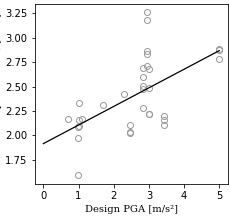

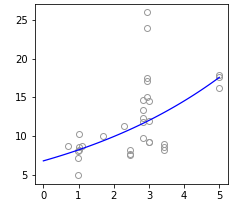

In [139]:
dfyy = RC_MRF_R.copy()
dfyy["mu"] = dfyy["med_c_PGA"] / dfyy["PGA_des"]
dfyy = dfyy[(dfyy["mu"] != np.inf)]
dfyy["ln_med"] = np.log(dfyy["med_c_PGA"])

ax1 = basic_1x1_figure()
ax1.plot(dfyy.PGA_des, dfyy["ln_med"], ls="", marker="o", mec="0.6", mfc="none")

mrf_final_res = my_curve_fit(linear_fn, dfyy.PGA_des, dfyy["ln_med"])
m_mrf = mrf_final_res[0][0]
c_mrf = mrf_final_res[0][1]
print(f"\nResults of fitting the log of the MRF Final Data with a Linear Function:")
print (f"m = {m_mrf}")
print (f"c = {c_mrf}")
print (f"r2 = {mrf_final_res[3]}")
pgas = np.linspace(0.01, 5)
dfyy_bf = linear_fn(PGAS, mrf_final_res[0][0], mrf_final_res[0][1])
# ax1 = basic_1x1_figure()
# ax1.plot(dfyy.PGA_des, dfyy["ln_med"], ls="", marker="o", mec="0.6", mfc="none")
ax1.plot(PGAS, dfyy_bf, ls="-", color="k", lw=1.25, label="linear of log best fit")
ax1.set_ylabel(r'Median Collapse PGA, $\theta_{c}$, [m/s²]', fontdict=axis_title_font, labelpad=1)
ax1.set_xlabel('Design PGA [m/s²]', fontdict=axis_title_font)

dfyy_bf22 = np.exp(dfyy_bf)
ax1 = basic_1x1_figure()
ax1.plot(dfyy.PGA_des, dfyy.med_c_PGA, ls="", marker="o", mec="0.6", mfc="none")
ax1.plot(PGAS, dfyy_bf22, ls="-", color="b", lw=1.25, label="linear of log best fit")

#### 3.1.4 Comparison of the different fits

Text(0.5, 0, 'Design PGA [m/s²]')

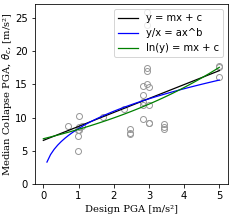

In [140]:
dfxx_bf22 = dfxx_bf * PGAS
ax1 = basic_1x1_figure()
ax1.plot(dfxx.PGA_des, dfxx.med_c_PGA, ls="", marker="o", mec="0.6", mfc="none")
ax1.plot(PGAS, rc_mrf_r_bf, ls="-", color="k", lw=1.25, label="y = mx + c")
ax1.plot(PGAS[1:], dfxx_bf22[1:], ls="-", color="b", lw=1.25, label="y/x = ax^b")
ax1.plot(PGAS, dfyy_bf22, ls="-", color="g", lw=1.25, label="ln(y) = mx + c")
ax1.legend()
ax1.set_ylim(0)
ax1.set_ylabel(r'Median Collapse PGA, $\theta_{c}$, [m/s²]', fontdict=axis_title_font, labelpad=1)
ax1.set_xlabel('Design PGA [m/s²]', fontdict=axis_title_font)


### 3.2 - RC-MRF-M

#### 3.2.1 Linear Fit 


Results of fitting data with a Linear Function:
m = 8.579825433023016
c = 1.864480706359418
r2 = 0.7542241887262751


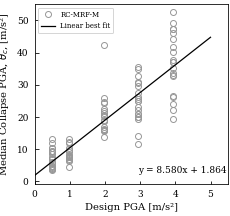

In [141]:
# fit curve
input_db = RC_MRF_M
label = "RC-MRF-M"
[rc_mrf_m_m, rc_mrf_m_c, res, rc_mrf_m_bf] = fitting_curve(input_db)

# Create plot
figure_name = "rc-mrf-m_best-fit"

ax1 = basic_1x1_figure()
plot_fit(ax1, input_db, rc_mrf_m_m, rc_mrf_m_c, rc_mrf_m_bf, label)

basic_1x1_format_and_save(ax1, figure_name)

Dispersion of median values: 0.3223776133767393


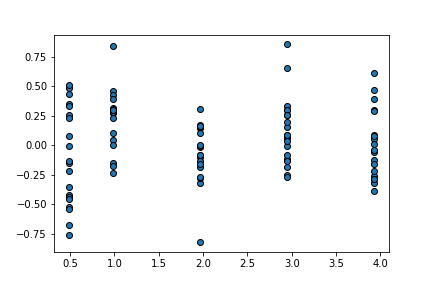

In [142]:
# characterising the variance around the regression curve
rc_mrf_m_beta_theta = dispersion(rc_mrf_m_m, rc_mrf_m_c, input_db)

#### 3.2.2 Power fit on mu/PGA_des


Results of fitting MRF Final Data with a Power Function:
a = 11.340503686214397
b = -0.23062988336464685
r2 = 0.18621710940314906


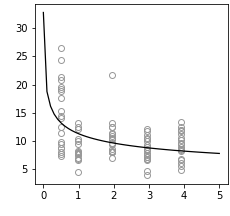

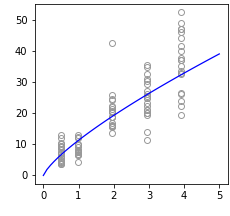

In [143]:
dfzz = RC_MRF_M.copy()
dfzz["mu"] = dfzz["med_c_PGA"] / dfzz["PGA_des"]
dfzz = dfzz[(dfzz["mu"] != np.inf)]
mrf_final_res = my_curve_fit(power2_fn, dfzz.PGA_des, dfzz.mu)
a_mrf = mrf_final_res[0][0]
b_mrf = mrf_final_res[0][1]
print(f"\nResults of fitting MRF Final Data with a Power Function:")
print (f"a = {a_mrf}")
print (f"b = {b_mrf}")
print (f"r2 = {mrf_final_res[3]}")
pgas = np.linspace(0.01, 5)
dfzz_bf = power2_fn(pgas, mrf_final_res[0][0], mrf_final_res[0][1])
ax1 = basic_1x1_figure()
ax1.plot(dfzz.PGA_des, dfzz.mu, ls="", marker="o", mec="0.6", mfc="none")
ax1.plot(PGAS, dfzz_bf, ls="-", color="k", lw=1.25, label="Power2 best fit")

dfzz_bf22 = dfzz_bf * PGAS
ax1 = basic_1x1_figure()
ax1.plot(dfzz.PGA_des, dfzz.med_c_PGA, ls="", marker="o", mec="0.6", mfc="none")
ax1.plot(PGAS, dfzz_bf22, ls="-", color="b", lw=1.25, label="Power2 best fit")

#### 3.2.3 Ln(Median) fit


Results of fitting the log of the MRF Final Data with a Linear Function:
m = 0.4940466882084886
c = 1.7296377613094611
r2 = 0.7793630998725146


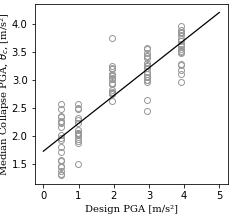

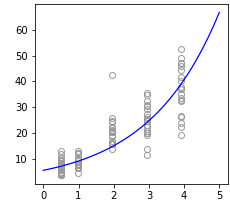

In [144]:
dfqq = RC_MRF_M.copy()
dfqq["mu"] = dfqq["med_c_PGA"] / dfqq["PGA_des"]
dfqq = dfqq[(dfqq["mu"] != np.inf)]
dfqq["ln_med"] = np.log(dfqq["med_c_PGA"])

ax1 = basic_1x1_figure()
ax1.plot(dfqq.PGA_des, dfqq["ln_med"], ls="", marker="o", mec="0.6", mfc="none")

mrf_final_res = my_curve_fit(linear_fn, dfqq.PGA_des, dfqq["ln_med"])
m_mrf = mrf_final_res[0][0]
c_mrf = mrf_final_res[0][1]
print(f"\nResults of fitting the log of the MRF Final Data with a Linear Function:")
print (f"m = {m_mrf}")
print (f"c = {c_mrf}")
print (f"r2 = {mrf_final_res[3]}")
pgas = np.linspace(0.01, 5)
dfqq_bf = linear_fn(PGAS, mrf_final_res[0][0], mrf_final_res[0][1])

ax1.plot(PGAS, dfqq_bf, ls="-", color="k", lw=1.25, label="linear of log best fit")
ax1.set_ylabel(r'Median Collapse PGA, $\theta_{c}$, [m/s²]', fontdict=axis_title_font, labelpad=1)
ax1.set_xlabel('Design PGA [m/s²]', fontdict=axis_title_font)

dfqq_bf22 = np.exp(dfqq_bf)
ax1 = basic_1x1_figure()
ax1.plot(dfqq.PGA_des, dfqq.med_c_PGA, ls="", marker="o", mec="0.6", mfc="none")
ax1.plot(PGAS, dfqq_bf22, ls="-", color="b", lw=1.25, label="linear of log best fit")

#### 3.2.4 Comparison of the different fits

Text(0.5, 0, 'Design PGA [m/s²]')

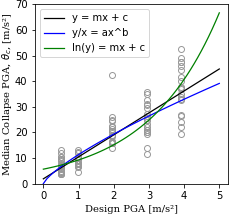

In [145]:
dfzz_bf22 = dfzz_bf * PGAS
ax1 = basic_1x1_figure()
ax1.plot(dfzz.PGA_des, dfzz.med_c_PGA, ls="", marker="o", mec="0.6", mfc="none")
ax1.plot(PGAS, rc_mrf_m_bf, ls="-", color="k", lw=1.25, label="y = mx + c")
ax1.plot(PGAS, dfzz_bf22, ls="-", color="b", lw=1.25, label="y/x = ax^b")
ax1.plot(PGAS, dfqq_bf22, ls="-", color="g", lw=1.25, label="ln(y) = mx + c")
ax1.legend()
ax1.set_ylim(0)
ax1.set_ylabel(r'Median Collapse PGA, $\theta_{c}$, [m/s²]', fontdict=axis_title_font, labelpad=1)
ax1.set_xlabel('Design PGA [m/s²]', fontdict=axis_title_font)

#### 3.2.3 Restricted Linear Fit


Results of fitting data with a Linear Function:
m = 9.067350043748002
c = 0.3698370502286821
r2 = 0.689367710444541


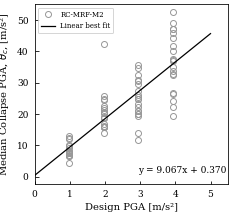

In [146]:
# fitting points for the pgas > 0.5
# fit curve
input_db = RC_MRF_M[RC_MRF_M.PGA_des > 0.5 ]
label = "RC-MRF-M2"

# fitting curve with slope and 0 intercept


[rc_mrf_m2_m, rc_mrf_m2_c, res, rc_mrf_m2_bf] = fitting_curve(input_db)

# Create plot
figure_name = "rc-mrf-m2_best-fit"

ax1 = basic_1x1_figure()
plot_fit(ax1, input_db, rc_mrf_m2_m, rc_mrf_m2_c, rc_mrf_m2_bf, label)

basic_1x1_format_and_save(ax1, figure_name)

#### 3.2.4 Restricted Power Fit


Results of fitting data with a Linear Function:
m = 9.466229589442761
c = -0.02567059981666986
r2 = 0.6895004588067518


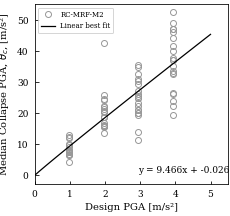

In [147]:
input_db = RC_MRF_M[RC_MRF_M.PGA_des > 0.5 ]
label = "RC-MRF-M2"

# fitting curve with slope and 0 intercept


[rc_mrf_m2_a, rc_mrf_m2_b, res, rc_mrf_m2_pbf] = fitting_curve(input_db, fn=power_fn)

# Create plot
figure_name = "rc-mrf-m2_power_best-fit"

ax1 = basic_1x1_figure()
plot_fit(ax1, input_db, rc_mrf_m2_a, rc_mrf_m2_b, rc_mrf_m2_pbf, label)

basic_1x1_format_and_save(ax1, figure_name)

### 3.3 - RC-WDS


Results of fitting data with a Linear Function:
m = 1.5356368825717106
c = 1.267578376779069
r2 = 0.41817051667660865


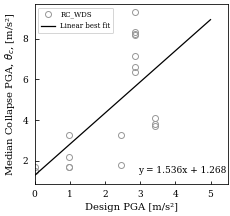

In [148]:
# fit curve
input_db = RC_WDS
label = "RC_WDS"
[rc_wds_m, rc_wds_c, res, rc_wds_bf] = fitting_curve(input_db)

# Create plot
figure_name = "rc-wds_best-fit"

ax1 = basic_1x1_figure()
plot_fit(ax1, input_db, rc_wds_m, rc_wds_c, rc_wds_bf, label)

basic_1x1_format_and_save(ax1, figure_name)

Dispersion of median values: 0.46004732308904644


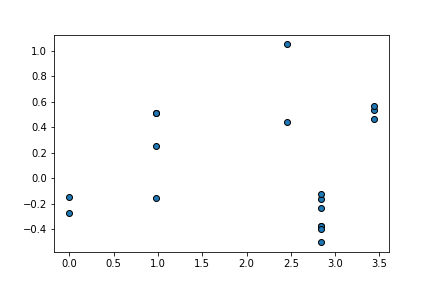

In [149]:
# characterising the variance around the regression curve
rc_wds_beta_theta = dispersion(rc_wds_m, rc_wds_c, input_db)

Linear comparison considering only the PGA values


Results of fitting data with a Linear Function:
m = 0.6270073020284479
c = 1.50479671110072
r2 = 0.6624294072724572


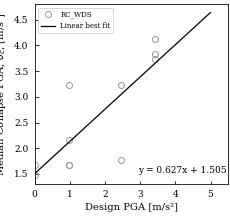

In [150]:
# fit curve
input_db = RC_WDS[RC_WDS["origin_IM"] == "PGA"]
label = "RC_WDS"
[rc_wds_pga_m, rc_wds_pga_c, res, rc_wds_pgabf] = fitting_curve(input_db)

# Create plot
figure_name = "rc-wds_pga_best-fit"

ax1 = basic_1x1_figure()
plot_fit(ax1, input_db, rc_wds_pga_m, rc_wds_pga_c, rc_wds_pgabf, label)

basic_1x1_format_and_save(ax1, figure_name)

### 3.4 - S-MRF


Results of fitting data with a Linear Function:
m = 1.8620121561725975
c = 5.41275396388888
r2 = 0.37811732905793705


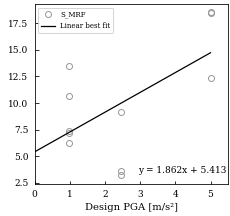

In [151]:
S_MRF_1 = S_MRF[(S_MRF["origin_IM"] == "PGA")]
S_MRF_2 = S_MRF[(S_MRF["origin_IM"] == "SA")]
# fit curve
input_db1 = S_MRF_1
label = "S_MRF"
[s_mrf_pga_m, s_mrf_pga_c, res, s_mrf_pgabf] = fitting_curve(input_db1)

# Create plot
figure_name = "s-mrf_best-fit"

ax1 = basic_1x1_figure()
plot_fit(ax1, input_db1, s_mrf_pga_m, s_mrf_pga_c, s_mrf_pgabf, label)
# ax1.set_ylim(0,20)

basic_1x1_format_and_save(ax1, figure_name)

Dispersion of median values: 1.3220903909862798


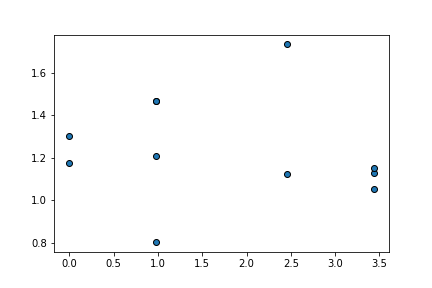

In [152]:
# characterising the variance around the regression curve
s_mef_beta_theta = dispersion(s_mrf_pga_m, s_mrf_pga_c, input_db)


Results of fitting data with a Linear Function:
m = 3.539118316485014
c = 14.898733927469051
r2 = 0.2240449255612852


(0.0, 50.0)

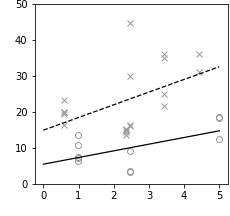

In [153]:
# fit curve
input_db2 = S_MRF_2
label = "S_MRF2"
[s_mrf_sa_m, s_mrf_sa_c, res, s_mrf_sabf] = fitting_curve(input_db2)

# Create plot
figure_name = "s-mrf_best-fit"

ax1 = basic_1x1_figure()
ax1.plot(input_db1.PGA_des, input_db1.med_c_PGA, ls="", marker="o", mec="0.6", mfc="none")
ax1.plot(input_db2.PGA_des, input_db2.med_c_PGA, ls="", marker="x", mec="0.6", mfc="none")
ax1.plot(PGAS, s_mrf_pgabf, ls="-", color="k", lw=1.25, label="PGA Linear fit")
ax1.plot(PGAS, s_mrf_sabf, ls="--", color="k", lw=1.25, label="SA Linear fit")
ax1.set_ylim(0,50)



#### 3.4.1 Power fit on mu/PGA_des


Results of fitting MRF Final Data with a Power Function:
a = 8.865319196639817
b = -1.0261309745883205
r2 = 0.6478684678831863


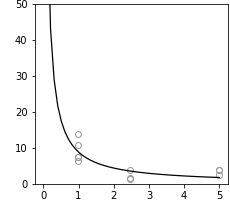

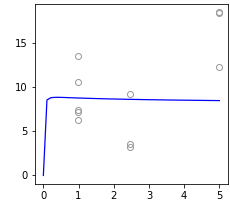

In [154]:
dftt = S_MRF_1.copy()
dftt["mu"] = dftt["med_c_PGA"] / dftt["PGA_des"]
dftt = dftt[(dftt["mu"] != np.inf)]
mrf_final_res = my_curve_fit(power2_fn, dftt.PGA_des, dftt.mu)
a_mrf = mrf_final_res[0][0]
b_mrf = mrf_final_res[0][1]
print(f"\nResults of fitting MRF Final Data with a Power Function:")
print (f"a = {a_mrf}")
print (f"b = {b_mrf}")
print (f"r2 = {mrf_final_res[3]}")
pgas = np.linspace(0.01, 5)
dftt_bf = power2_fn(pgas, mrf_final_res[0][0], mrf_final_res[0][1])
ax1 = basic_1x1_figure()
ax1.plot(dftt.PGA_des, dftt.mu, ls="", marker="o", mec="0.6", mfc="none")
ax1.plot(PGAS, dftt_bf, ls="-", color="k", lw=1.25, label="Power2 best fit")
ax1.set_ylim(0,50)

dftt_bf22 = dftt_bf * PGAS
ax1 = basic_1x1_figure()
ax1.plot(dftt.PGA_des, dftt.med_c_PGA, ls="", marker="o", mec="0.6", mfc="none")
ax1.plot(PGAS, dftt_bf22, ls="-", color="b", lw=1.25, label="Power2 best fit")

#### 3.4.2 Ln(Median) fit


Results of fitting the log of the MRF Final Data with a Linear Function:
m = 0.15774723820810654
c = 1.7717002064212013
r2 = 0.21913053697051954


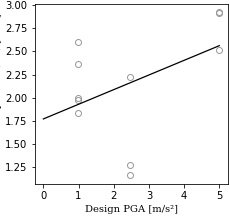

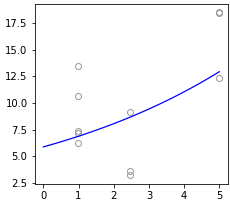

In [155]:
dfuu = S_MRF_1.copy()
dfuu["mu"] = dfuu["med_c_PGA"] / dfuu["PGA_des"]
dfuu = dfuu[(dfuu["mu"] != np.inf)]
dfuu["ln_med"] = np.log(dfuu["med_c_PGA"])

ax1 = basic_1x1_figure()
ax1.plot(dfuu.PGA_des, dfuu["ln_med"], ls="", marker="o", mec="0.6", mfc="none")

mrf_final_res = my_curve_fit(linear_fn, dfuu.PGA_des, dfuu["ln_med"])
m_mrf = mrf_final_res[0][0]
c_mrf = mrf_final_res[0][1]
print(f"\nResults of fitting the log of the MRF Final Data with a Linear Function:")
print (f"m = {m_mrf}")
print (f"c = {c_mrf}")
print (f"r2 = {mrf_final_res[3]}")
pgas = np.linspace(0.01, 5)
dfuu_bf = linear_fn(PGAS, mrf_final_res[0][0], mrf_final_res[0][1])

ax1.plot(PGAS, dfuu_bf, ls="-", color="k", lw=1.25, label="linear of log best fit")
ax1.set_ylabel(r'Median Collapse PGA, $\theta_{c}$, [m/s²]', fontdict=axis_title_font, labelpad=1)
ax1.set_xlabel('Design PGA [m/s²]', fontdict=axis_title_font)

dfuu_bf22 = np.exp(dfuu_bf)
ax1 = basic_1x1_figure()
ax1.plot(dfuu.PGA_des, dfuu.med_c_PGA, ls="", marker="o", mec="0.6", mfc="none")
ax1.plot(PGAS, dfuu_bf22, ls="-", color="b", lw=1.25, label="linear of log best fit")

#### 3.4.3 Comparison of the different fits

Text(0.5, 0, 'Design PGA [m/s²]')

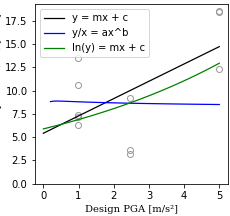

In [156]:
dftt_bf22 = dftt_bf * PGAS
ax1 = basic_1x1_figure()
ax1.plot(dftt.PGA_des, dftt.med_c_PGA, ls="", marker="o", mec="0.6", mfc="none")
ax1.plot(PGAS, s_mrf_pgabf, ls="-", color="k", lw=1.25, label="y = mx + c")
ax1.plot(PGAS[2:], dftt_bf22[2:], ls="-", color="b", lw=1.25, label="y/x = ax^b")
ax1.plot(PGAS, dfuu_bf22, ls="-", color="g", lw=1.25, label="ln(y) = mx + c")
ax1.legend()
ax1.set_ylim(0)
ax1.set_ylabel(r'Median Collapse PGA, $\theta_{c}$, [m/s²]', fontdict=axis_title_font, labelpad=1)
ax1.set_xlabel('Design PGA [m/s²]', fontdict=axis_title_font)

## 4.0 - Dispersion Values

### 4.1 - RC MRFS and DWS

In [157]:
# fitting curve for RC-MRF-M
input_db = RC_MRF_M
[m, c, res, rc_mrf_m_beta_bf] = fitting_curve(input_db, tag="beta_c_PGA")




Results of fitting data with a Linear Function:
m = 0.06161418888281596
c = 0.5694304480636223
r2 = 0.3858213136877098


Dispersion of beta values for all a_gdes: 0.09814431409990892
Dispersion of beta values for a_gdes > 0.5 ms-2: 0.1028905472806183


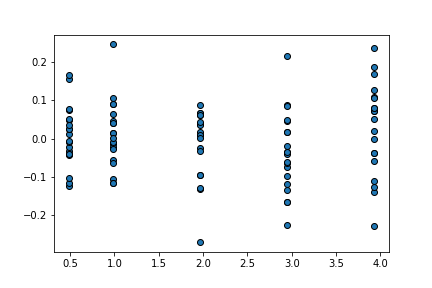

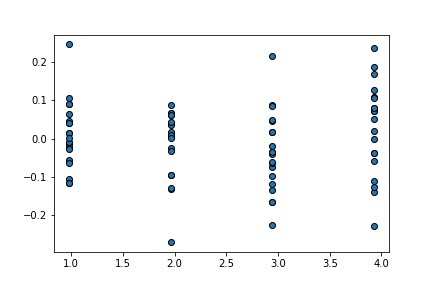

In [158]:
# Variation of the dispersion values for RC-MRF-M about the best fit
# considering all a_gdes values
err = [(m*row["PGA_des"] + (c)) - (row["beta_c_PGA"]) for idx, row in RC_MRF_M.iterrows()]
n = len(err)
plt.figure()
plt.plot(RC_MRF_M["PGA_des"], err, "o", mec="k")

err = np.array(err)
beta = np.sqrt((1 / (n-1)) * sum(err ** 2))
print(f"Dispersion of beta values for all a_gdes: {beta}")

# excluding a_gdes < 0.5 ms^-2
temp = RC_MRF_M[RC_MRF_M.PGA_des > 0.5]
err = [(m*row["PGA_des"] + (c)) - (row["beta_c_PGA"]) for idx, row in temp.iterrows()]
n = len(err)
plt.figure()
plt.plot(temp["PGA_des"], err, "o", mec="k")

err = np.array(err)
beta = np.sqrt((1 / (n-1)) * sum(err ** 2))
print(f"Dispersion of beta values for a_gdes > 0.5 ms-2: {beta}")


In [159]:
# RC-MRF-R mean value of beta and dispersion
temp = RC_MRF_R[RC_MRF_R.beta_c_PGA != 0]
temp = temp[temp.Author != "Nazri and Saruddin"]
beta_mean = np.mean(temp.beta_c_PGA)
err = np.array(temp["beta_c_PGA"]) -  beta_mean
n = len(err)
err = np.array(err)
beta_beta = np.sqrt((1 / (n-1)) * sum(err ** 2))
print(f"RC-MRF-R:\nMean beta value: {beta_mean}\nDispersion of beta values: {beta_beta}")


RC-MRF-R:
Mean beta value: 0.5306896551724138
Dispersion of beta values: 0.12254098540263282


In [160]:
# RC-MRF-R mean value of beta and dispersion for PGA origin only
temp = RC_MRF_R[RC_MRF_R.beta_c_PGA != 0]
temp = temp[temp["origin_IM"] != "SA"]
temp = temp[temp.Author != "Nazri and Saruddin"]
beta_mean = np.mean(temp.beta_c_PGA)
err = np.array(temp["beta_c_PGA"]) -  beta_mean
n = len(err)
err = np.array(err)
beta_beta = np.sqrt((1 / (n-1)) * sum(err ** 2))
print(f"RC-MRF-R:\nMean beta value: {beta_mean}\nDispersion of beta values: {beta_beta}")

RC-MRF-R:
Mean beta value: 0.535
Dispersion of beta values: 0.12857993622645797


In [161]:
# RC-MRF-R mean value of beta and dispersion for Dynamic analyses only
temp = RC_MRF_R[RC_MRF_R.beta_c_PGA != 0]
temp = temp[temp["Method"] != "SPO"]
temp = temp[temp.Author != "Nazri and Saruddin"]
beta_mean = np.mean(temp.beta_c_PGA)
err = np.array(temp["beta_c_PGA"]) -  beta_mean
n = len(err)
err = np.array(err)
beta_beta = np.sqrt((1 / (n-1)) * sum(err ** 2))
print(f"RC-MRF-R:\nMean beta value: {beta_mean}\nDispersion of beta values: {beta_beta}")

RC-MRF-R:
Mean beta value: 0.5505000000000001
Dispersion of beta values: 0.09402267363723887


In [162]:
# RC-MRF-R mean value of beta and dispersion for static analyses only
temp = RC_MRF_R[RC_MRF_R.beta_c_PGA != 0]
temp = temp[temp["Method"] == "SPO"]
temp = temp[temp.Author != "Nazri and Saruddin"]
beta_mean = np.mean(temp.beta_c_PGA)
err = np.array(temp["beta_c_PGA"]) -  beta_mean
n = len(err)
err = np.array(err)
beta_beta = np.sqrt((1 / (n-1)) * sum(err ** 2))
print(f"RC-MRF-R:\nMean beta value: {beta_mean}\nDispersion of beta values: {beta_beta}")

RC-MRF-R:
Mean beta value: 0.48666666666666675
Dispersion of beta values: 0.16852299546352717


In [163]:
# RC-WDS mean value of beta and dispersion
temp = RC_WDS[RC_WDS.beta_c_PGA != 0]
beta_mean = np.mean(temp.beta_c_PGA)
err = np.array(temp["beta_c_PGA"]) -  beta_mean
n = len(err)
err = np.array(err)
beta_beta = np.sqrt((1 / (n-1)) * sum(err ** 2))
print(f"RC-WDS:\nMean beta value: {beta_mean}\nDispersion of beta values: {beta_beta}")

RC-WDS:
Mean beta value: 0.3522222222222222
Dispersion of beta values: 0.18571184369578825


In [164]:
# RC-WDS mean value of beta and dispersion for PGA only
temp = RC_WDS[RC_WDS.beta_c_PGA != 0]
temp = temp[temp["origin_IM"] == "PGA"]
beta_mean = np.mean(temp.beta_c_PGA)
err = np.array(temp["beta_c_PGA"]) -  beta_mean
n = len(err)
err = np.array(err)
beta_beta = np.sqrt((1 / (n-1)) * sum(err ** 2))
print(f"RC-WDS:\nMean beta value: {beta_mean}\nDispersion of beta values: {beta_beta}")

RC-WDS:
Mean beta value: 0.21727272727272728
Dispersion of beta values: 0.08186463327846881


In [165]:
# S-MRF mean value of beta and dispersion
temp = S_MRF[S_MRF.beta_c_PGA != 0]
beta_mean = np.mean(temp.beta_c_PGA)
err = np.array(temp["beta_c_PGA"]) -  beta_mean
n = len(err)
err = np.array(err)
beta_beta = np.sqrt((1 / (n-1)) * sum(err ** 2))
print(f"S_MRF:\nMean beta value: {beta_mean}\nDispersion of beta values: {beta_beta}")

S_MRF:
Mean beta value: 0.2730555555555555
Dispersion of beta values: 0.1092985507800281


In [166]:
# S-MRF mean value of beta and dispersion PGA only
temp = S_MRF[S_MRF.beta_c_PGA != 0]
temp = temp[temp["origin_IM"] == "PGA"]
beta_mean = np.mean(temp.beta_c_PGA)
err = np.array(temp["beta_c_PGA"]) -  beta_mean
n = len(err)
err = np.array(err)
beta_beta = np.sqrt((1 / (n-1)) * sum(err ** 2))
print(f"S_MRF:\nMean beta value: {beta_mean}\nDispersion of beta values: {beta_beta}")

S_MRF:
Mean beta value: 0.239375
Dispersion of beta values: 0.16006689449816194


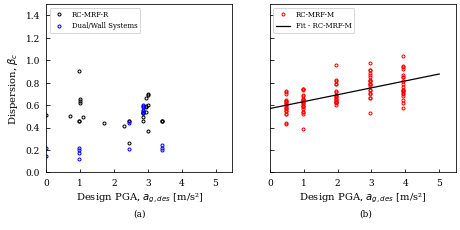

In [167]:
figure_name = "Fig7_rc_betas"

## filter out the null or irrelevant dispersion values
rc_mrf_r_beta = RC_MRF_R[RC_MRF_R.beta_c_PGA.notna()]
rc_mrf_r_beta = rc_mrf_r_beta[rc_mrf_r_beta.Author != "Nazri and Saruddin"]
rc_mrf_r_beta = rc_mrf_r_beta[rc_mrf_r_beta.Author != "Zizimond and Dolsek"]
rc_wds_beta = RC_WDS[RC_WDS.beta_c_PGA.notna()]

# initialise the figure
[ax1, ax2] = basic_1x2_figure()

ax1.plot(rc_mrf_r_beta.PGA_des, rc_mrf_r_beta.beta_c_PGA, ls="", marker=".", mec="k", mfc="none", label="RC-MRF-R")
ax1.plot(rc_wds_beta.PGA_des, rc_wds_beta.beta_c_PGA, ls="", marker=".", mec="b", mfc="none", label="Dual/Wall Systems")

ax2.plot(RC_MRF_M.PGA_des, RC_MRF_M.beta_c_PGA, ls="", marker=".", mec="r", mfc="none", label="RC-MRF-M")
ax2.plot(PGAS, rc_mrf_m_beta_bf, ls="-", color="k", lw=1.25, label="Fit - RC-MRF-M")


ax1.set_ylabel(r'Dispersion, $\beta_{c}$', fontdict=axis_title_font, labelpad=6)
ax1.set_xlabel(r'Design PGA, $a_{g,des}$ [m/s²]', fontdict=axis_title_font)
ax2.set_xlabel(r'Design PGA, $a_{g,des}$ [m/s²]', fontdict=axis_title_font)

ax1.set_xlim(0, 5.5)
ax1.set_ylim(0, 1.5)

basic_1x2_format_and_save(ax1, ax2, figure_name)

### 4.2 - Steel MRFs

In [168]:
## filter out the null or irrelevant dispersion values
s_mrf_beta = S_MRF[S_MRF.beta_c_PGA.notna()]
# s_mrf_beta = s_mrf_beta[s_mrf_beta.Author != "Nazri and Saruddin"]
s_mrf_beta = s_mrf_beta[s_mrf_beta.beta_c_PGA != 0]

## best fit line as the dispersion is linear
input_db = s_mrf_beta
[m, c, res, s_mrf_beta_bf] = fitting_curve(input_db, tag="beta_c_PGA")


Results of fitting data with a Linear Function:
m = 0.014078342696832493
c = 0.22989135696753102
r2 = 0.02993806721016512


## Inherent Capacities

The inherent capacities are calculated as the average value of all point below a_g = 1 ms-2. The plateau is then intersected with the regression line

Databases

In [169]:

RC_MRF_R_DYN = RC_MRF_R[RC_MRF_R["Method"] != "SPO"]
RC_MRF_R_STAT = RC_MRF_R[RC_MRF_R["Method"] == "SPO"]
RC_WDS_PGA = RC_WDS[RC_WDS["origin_IM"] == "PGA"]
S_MRF_PGA = S_MRF[S_MRF["origin_IM"] == "PGA"]
S_MRF_SA = S_MRF[S_MRF["origin_IM"] == "SA"]

In [170]:
rc_mrf_m_ic = RC_MRF_M[RC_MRF_M["PGA_des"] <= 1.0]["med_c_PGA"].mean()
print(f"RC-MRF-M inherent capacity: {rc_mrf_m_ic:.3f} ms-2")

rc_mrf_r_ic = RC_MRF_R[RC_MRF_R["PGA_des"] <= 1.0]["med_c_PGA"].mean()
rc_mrf_r_dyn_ic = RC_MRF_R_DYN[RC_MRF_R_DYN["PGA_des"] <= 1.0]["med_c_PGA"].mean()
rc_mrf_r_stat_ic = RC_MRF_R_STAT[RC_MRF_R_STAT["PGA_des"] <= 1.0]["med_c_PGA"].mean()
print(f"RC-MRF-R inherent capacity: {rc_mrf_r_ic:.3f} ms-2")
print(f"RC-MRF-R-DYN inherent capacity: {rc_mrf_r_dyn_ic:.3f} ms-2")
print(f"RC-MRF-R-STAT inherent capacity: {rc_mrf_r_stat_ic:.3f} ms-2")

rc_wds_ic = RC_WDS[RC_WDS["PGA_des"] <= 1.0]["med_c_PGA"].mean()
rc_wds_pga_ic = RC_WDS_PGA[RC_WDS_PGA["PGA_des"] <= 1.0]["med_c_PGA"].mean()
print(f"RC-WDS inherent capacity: {rc_wds_ic:.3f} ms-2")
print(f"RC-WDS-PGA inherent capacity: {rc_wds_pga_ic:.3f} ms-2")

s_mrf_pga_ic = S_MRF_PGA[S_MRF_PGA["PGA_des"] <= 1.0]["med_c_PGA"].mean()
s_mrf_sa_ic = S_MRF_SA[S_MRF_SA["PGA_des"] <= 1.0]["med_c_PGA"].mean()
print(f"S-MRF-PGA inherent capacity: {s_mrf_pga_ic:.3f} ms-2")
print(f"S-MRF-SA inherent capacity: {s_mrf_sa_ic:.3f} ms-2")


RC-MRF-M inherent capacity: 7.843 ms-2
RC-MRF-R inherent capacity: 8.090 ms-2
RC-MRF-R-DYN inherent capacity: 8.922 ms-2
RC-MRF-R-STAT inherent capacity: 6.704 ms-2
RC-WDS inherent capacity: 1.978 ms-2
RC-WDS-PGA inherent capacity: 1.978 ms-2
S-MRF-PGA inherent capacity: 9.006 ms-2
S-MRF-SA inherent capacity: 19.769 ms-2


## 5.0 - Comparison Plots and Figures

### 5.1 - Figure 5: RC Median Value Relationships

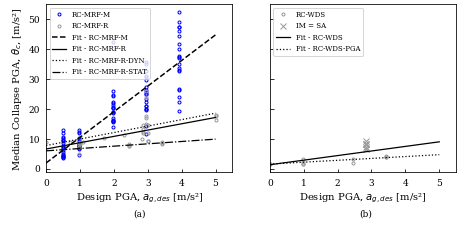

In [171]:
# initialise the figure
figure_name = "Fig5_rc_comparison"
[ax1, ax2] = basic_1x2_figure()

ax1.plot(RC_MRF_M.PGA_des, RC_MRF_M.med_c_PGA, ls="", marker=".", mec="b", mfc="none", label="RC-MRF-M")
ax1.plot(RC_MRF_R.PGA_des, RC_MRF_R.med_c_PGA, ls="", marker=".", mec="0.6", mfc="none", label="RC-MRF-R")
ax1.plot(PGAS, rc_mrf_m_bf, ls="--", color="k", label="Fit - RC-MRF-M")
ax1.plot(PGAS, rc_mrf_r_bf, ls="-", color="k", lw=1.25, label="Fit - RC-MRF-R")
ax1.plot(PGAS, rc_mrf_r_dynbf, ls=":", color="k", lw=1.25, label="Fit - RC-MRF-R-DYN")
ax1.plot(PGAS, rc_mrf_r_statbf, ls="-.", color="k", lw=1.25, label="Fit - RC-MRF-R-STAT")

ax1.set_xlim(0, 5.5)

temp = RC_WDS[RC_WDS["origin_IM"]=="PGA"]
temp2 = RC_WDS[RC_WDS["origin_IM"]=="SA"]
ax2.plot(temp.PGA_des, temp.med_c_PGA, ls="", marker=".", mec="0.6", mfc="none", label="RC-WDS")
ax2.plot(temp2.PGA_des, temp2.med_c_PGA, ls="", marker="x", mec="0.6", mfc="none", label="IM = SA")
ax2.plot(PGAS, rc_wds_bf, ls="-", color="k", lw=1.25, label="Fit - RC-WDS")
ax2.plot(PGAS, rc_wds_pgabf, ls=":", color="k", lw=1.25, label="Fit - RC-WDS-PGA")
ax2.set_xlim(0, 5.5)

ax1.set_ylabel(r'Median Collapse PGA, $\theta_{c}$, [m/s²]', fontdict=axis_title_font)
ax1.set_xlabel(r'Design PGA, $a_{g,des}$ [m/s²]', fontdict=axis_title_font)
ax2.set_xlabel(r'Design PGA, $a_{g,des}$ [m/s²]', fontdict=axis_title_font)

basic_1x2_format_and_save(ax1, ax2, figure_name)




### 5.2 - Figure 9: Steel Median and Dispersion

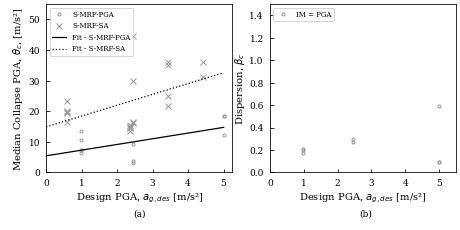

In [172]:
figure_name = "Fig8_steel_summary"

fig = plt.figure(figsize=(6.4,3.2))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1],
                    wspace=0.2, hspace=0.2, top=0.98, bottom=0.25, left=0.1, right=0.99)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

ax1.plot(S_MRF_1.PGA_des, S_MRF_1.med_c_PGA, ls="", marker=".", mec="0.6", mfc="none", label="S-MRF-PGA")
ax1.plot(S_MRF_2.PGA_des, S_MRF_2.med_c_PGA, ls="", marker="x", mec="0.6", mfc="none", label="S-MRF-SA")
ax1.plot(PGAS, s_mrf_pgabf, ls="-", color="k", lw=1.25, label="Fit - S-MRF-PGA")
ax1.plot(PGAS, s_mrf_sabf, ls=":", color="k", lw=1.25, label="Fit - S-MRF-SA")

ax2.plot(s_mrf_beta[s_mrf_beta["origin_IM"]=="PGA"].PGA_des, s_mrf_beta[s_mrf_beta["origin_IM"]=="PGA"].beta_c_PGA, ls="", marker=".", mec="0.6", mfc="none", label="IM = PGA")
# ax2.plot(s_mrf_beta[s_mrf_beta["origin_IM"]=="SA"].PGA_des, s_mrf_beta[s_mrf_beta["origin_IM"]=="SA"].beta_c_PGA, ls="", marker="x", mec="0.6", mfc="none", label="IM = SA")

ax1.set_ylabel(r'Median Collapse PGA, $\theta_{c}$, [m/s²]', fontdict=axis_title_font, labelpad=3)
ax1.set_xlabel(r'Design PGA, $a_{g,des}$ [m/s²]', fontdict=axis_title_font)
ax1.set_xlim(0)
ax1.set_ylim(0, 55)

ax2.set_ylabel(r'Dispersion, $\beta_{c}$', fontdict=axis_title_font, labelpad=2)
ax2.set_xlabel(r'Design PGA, $a_{g,des}$ [m/s²]', fontdict=axis_title_font)
ax2.set_xlim(0, 5.5)
ax2.set_ylim(0, 1.5)

for label in ax1.get_yticklabels() :
        label.set_fontproperties(axis_ticklabel_font)
        
for ax in [ax1, ax2]:
    for label in ax.get_xticklabels() :
        label.set_fontproperties(axis_ticklabel_font)
        
    ax.legend(prop=legend_font, loc=2)
    
    ax.tick_params('both', direction='in', which='both', pad=6)
    
for label in ax2.get_yticklabels() :
    label.set_fontproperties(axis_ticklabel_font)
    
# plt.setp(ax2.get_yticklabels(), visible=False)

plt.annotate("(a)", (0.29,0.06), xycoords="figure fraction", fontproperties= annotation_font)
plt.annotate("(b)", (0.78,0.06), xycoords="figure fraction", fontproperties= annotation_font)

plt.savefig(figure_folder / figure_name, dpi=800)
plt.savefig(figure_folder / (figure_name + "." + file_type), dpi=800, format=file_type)

# basic_1x2_format_and_save(ax1, ax2, figure_name)

### 5.3 - Figure 8: Fragility curve comparison

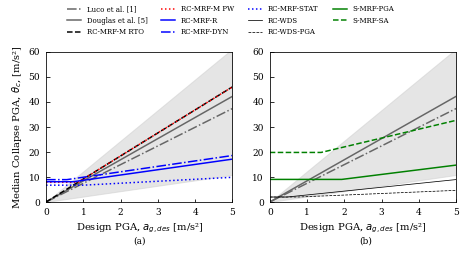

In [173]:
# plotting fragility curves used in previous studies
last = 80
pgas_for_frag = np.linspace(0.001, last, 400)
imx = 0.5 # m/s²  assumed as the design pga
cr_pgas = np.insert(np.linspace(0.5, 5),0, 0)

pgas_bf = np.array([0, 0.5, 5.0])

## 475 yr RTP
class fragility_curve(object):
    def __init__(self, imx, beta, x):
        self.imx = imx
        self.beta = beta
        self.x = x
        
    def fc(self, ims):
        y = (np.log(ims) - (np.log(self.imx) - norm.ppf(self.x) * self.beta)) / self.beta
        return norm.cdf(y)
        
    def median(self):
        return np.exp(np.log(self.imx) - norm.ppf(self.x)*self.beta)
        
    def cr(self):
        return self.median() / self.imx

# Douglas et al. 2013
douglas = fragility_curve(imx, beta=0.5, x=0.00001)
# Silva et al. 2016
silva =  fragility_curve(imx, beta=0.6, x=0.001)
# Vacareanu et al. 2018
vacareanu_1 =  fragility_curve(imx, beta=0.8, x=0.001)
vacareanu_2 =  fragility_curve(imx, beta=0.6, x=0.1)
vacareanu_3 =  fragility_curve(imx, beta=0.8, x=0.1)
# Taherian and Kalantari 2019
taherian =  fragility_curve(imx, beta=0.8, x=0.01)
# Kharazian et al. 2021
#kharazian_1 =  fragility_curve(imx, beta=0.8, x=0.000015)
kharazian_2 =  fragility_curve(imx, beta=0.8, x=0.0062)
kharazian_3 =  fragility_curve(imx, beta=0.6, x=0.000015)
kharazian_4 =  fragility_curve(imx, beta=0.6, x=0.0062)
# Pereira et al. 2022
pereira =  fragility_curve(imx, beta=0.6, x=0.0001)
# Luco et al. 2003
luco = fragility_curve(imx, beta=0.8, x=0.006)

# maximum and minimum curves for shading
fcs_og = [douglas, silva, vacareanu_1, vacareanu_2, vacareanu_3, taherian,
        kharazian_2, kharazian_3, kharazian_4, pereira, luco]
       
l = len(pgas_for_frag)
fcs = [np.reshape(f.fc(pgas_for_frag), (l,1)) for f in fcs_og]
fcs = np.hstack(fcs)

max_fcs = np.amax(fcs, 1)
min_fcs = np.amin(fcs, 1)

# maximum and minimum capacity reserve ratios for shading
max_crr = max([f.cr() for f in fcs_og])
min_crr = min([f.cr() for f in fcs_og])

# generic fragility curve theta functions
max_theta = pgas_bf * max_crr
min_theta = pgas_bf * min_crr

silva_theta = pgas_bf * silva.cr()
douglas_theta = pgas_bf * douglas.cr()
luco_theta = pgas_bf * luco.cr()

# Building specific theta functions
def theta_function(m, c, ic, x_end):
    x_plateau = (ic - c) / m
    x_values = [0, x_plateau, x_end]
    y_values = [ic, ic, x_end * m + c]
    return x_values, y_values, x_plateau


rc_mrf_r_x, rc_mrf_r_y, rc_mrf_r_plateau = theta_function(rc_mrf_r_m, rc_mrf_r_c, rc_mrf_r_ic, 5)
rc_mrf_r_dyn_x, rc_mrf_r_dyn_y, rc_mrf_r_dyn_plateau = theta_function(rc_mrf_r_dyn_m, rc_mrf_r_dyn_c, rc_mrf_r_dyn_ic, 5)
rc_mrf_r_stat_x, rc_mrf_r_stat_y, rc_mrf_r_stat_plateau = theta_function(rc_mrf_r_stat_m, rc_mrf_r_stat_c, rc_mrf_r_stat_ic, 5)

# the RTO version
rc_mrf_m_rto_x = np.array([0, 5])
rc_mrf_m_rto_y = linear_fn(rc_mrf_m_rto_x, 9.193016666666667, 0)
# RTO with plateau
rc_mrf_m_x, rc_mrf_m_y, rc_mrf_m_plateau = theta_function(9.193016666666667, 0, rc_mrf_m_ic, 5)

# RTO with plateau
# rc_mrf_m_plat_x = np.array([0, 0.8531045666910209, 5])
# rc_mrf_m_plat_y = np.array([7.8426045, 7.8426045, 5 * 9.193016666666667])


rc_wds_x, rc_wds_y, rc_wds_plateau = theta_function(rc_wds_m, rc_wds_c, rc_wds_ic, 5)
rc_wds_pga_x, rc_wds_pga_y, rc_wds_pga_plateau = theta_function(rc_wds_pga_m, rc_wds_pga_c, rc_wds_pga_ic, 5)
# rc_wds_theta = rc_wds_m * pgas_bf + rc_wds_c
# rc_wds_pga_theta = rc_wds_pga_m * pgas_bf + rc_wds_pga_c
# rc_wds_theta[0] = rc_wds_theta[1]

s_mrf_pga_x, s_mrf_pga_y, s_mrf_pga_plateau = theta_function(s_mrf_pga_m, s_mrf_pga_c, s_mrf_pga_ic, 5)
s_mrf_sa_x, s_mrf_sa_y, s_mrf_sa_plateau = theta_function(s_mrf_sa_m, s_mrf_sa_c, s_mrf_sa_ic, 5)
# s_mrf_pga_theta = s_mrf_pga_m * pgas_bf + s_mrf_pga_c
# s_mrf_sa_theta = s_mrf_sa_m * pgas_bf + s_mrf_sa_c
# s_mrf_theta[0] = s_mrf_theta[1]

# Plots
figure_name = "Fig9_fragility_curves"
fig10 = plt.figure(figsize=(6.4, 3.6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1],
                       wspace=0.2, hspace=0.2, top=0.80, bottom=0.22, left=0.1, right=0.99)
ax1 = fig10.add_subplot(gs[0,0])
ax2 = fig10.add_subplot(gs[0,1])


# Plot (a) - comparison of the PGA/Theta relationships
ax1.fill_between(pgas_bf, max_theta, min_theta, color="0.8", alpha=0.5)
ax1.plot(pgas_bf, luco_theta, ls="-.", color="0.4", marker="", label="Luco et al. [1]")
ax1.plot(pgas_bf, douglas_theta, ls="-", color="0.4", marker="", label="Douglas et al. [5]")
# ax1.plot(pgas_bf, silva_theta, ls="--", color="0.4", marker="", label="Silva et al. [4]")

ax1.plot(rc_mrf_m_rto_x, rc_mrf_m_rto_y, ls="--", color="k", marker="", label="RC-MRF-M RTO")
ax1.plot(rc_mrf_m_x, rc_mrf_m_y, ls=":", color="r", marker="", label="RC-MRF-M PW")
ax1.plot(rc_mrf_r_x, rc_mrf_r_y, ls="-", color="b", marker="", label="RC-MRF-R")
ax1.plot(rc_mrf_r_dyn_x, rc_mrf_r_dyn_y, ls="-.", color="b", marker="", label="RC-MRF-DYN")
ax1.plot(rc_mrf_r_stat_x, rc_mrf_r_stat_y, ls=":", color="b", marker="", label="RC-MRF-STAT")

ax1.set_xlabel(r'Design PGA, $a_{g,des}$ [m/s²]', fontdict=axis_title_font)
ax1.set_ylabel(r'Median Collapse PGA, $\theta_{c}$, [m/s²]', fontdict=axis_title_font)
ax1.set_ylim(0, 60)
ax1.set_xlim(0, 5)

ax2.fill_between(pgas_bf, max_theta, min_theta, color="0.8", alpha=0.5)
ax2.plot(pgas_bf, luco_theta, ls="-.", color="0.4", marker="")
ax2.plot(pgas_bf, douglas_theta, ls="-", color="0.4", marker="")
ax2.plot(rc_wds_x, rc_wds_y, ls="-", color="k", marker="", label="RC-WDS", lw=0.75)
ax2.plot(rc_wds_pga_x, rc_wds_pga_y, ls="--", color="k", marker="", label="RC-WDS-PGA", lw=0.75)
ax2.plot(s_mrf_pga_x, s_mrf_pga_y, ls="-", color="g", marker="", label="S-MRF-PGA")
ax2.plot(s_mrf_sa_x, s_mrf_sa_y, ls="--", color="g", marker="", label="S-MRF-SA")

ax2.set_xlabel(r'Design PGA, $a_{g,des}$ [m/s²]', fontdict=axis_title_font)
ax2.set_ylim(0, 60)
ax2.set_xlim(0, 5)

for ax in [ax1, ax2]:
    for label in ax.get_xticklabels() :
        label.set_fontproperties(axis_ticklabel_font)
        
    for label in ax.get_yticklabels() :
        label.set_fontproperties(axis_ticklabel_font)

    
    ax.tick_params('both', direction='in', which='both', pad=6)     

fig10.legend(prop=legend_font, ncol=4, loc='center', bbox_to_anchor=(0.5, 0.92), frameon=False)
handles_1, labels_1 = ax1.get_legend_handles_labels()
handles_2, labels_2 = ax2.get_legend_handles_labels()
handles = handles_1 + handles_2
labels = labels_1 + labels_2

plt.annotate("(a)", (0.29,0.06), xycoords="figure fraction", fontproperties= annotation_font)
plt.annotate("(b)", (0.78,0.06), xycoords="figure fraction", fontproperties= annotation_font)

plt.savefig(figure_folder / figure_name, dpi=800)
pdf_fig = plt.savefig(figure_folder / (figure_name + "." + file_type), dpi=800, format=file_type)


Calculation of Fragility Curves for two different design PGAs

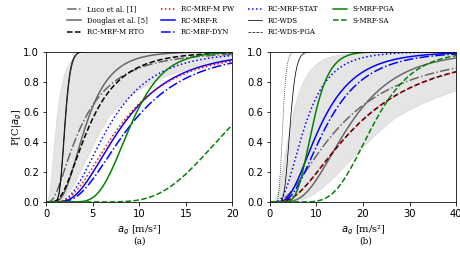

In [174]:
figure_name = "Fig11_fragility_curves"
fig11 = plt.figure(figsize=(6.4, 3.6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1],
                       wspace=0.2, hspace=0.2, top=0.80, bottom=0.22, left=0.1, right=0.99)
ax1 = fig11.add_subplot(gs[0,0])
ax2 = fig11.add_subplot(gs[0,1])

# Fragility curves for imx [ms-2]
imx_1 = 0.5
imx_2 = 2

def fragility(imx, pgas, m, c, ic, im_plat, beta):
    if imx <= im_plat:
        return norm.cdf((np.log(pgas) - np.log(ic)) / beta)
    else:
        return norm.cdf((np.log(pgas) - np.log(m * imx + c)) / beta)


# imx_1
douglas = fragility_curve(imx_1, beta=0.5, x=0.00001)
luco = fragility_curve(imx_1, beta=0.8, x=0.006)


rc_mrf_r_fc = fragility(imx_1, pgas_for_frag, rc_mrf_r_m, rc_mrf_r_c, rc_mrf_r_ic, rc_mrf_r_plateau, 0.56)
rc_mrf_r_dyn_fc = fragility(imx_1, pgas_for_frag, rc_mrf_r_dyn_m, rc_mrf_r_dyn_c, rc_mrf_r_dyn_ic, rc_mrf_r_dyn_plateau, 0.56)
rc_mrf_r_stat_fc = fragility(imx_1, pgas_for_frag, rc_mrf_r_stat_m, rc_mrf_r_stat_c, rc_mrf_r_stat_ic, rc_mrf_r_stat_plateau, 0.56)

# rc_mrf_r_fc = norm.cdf((np.log(pgas_for_frag) - np.log(rc_mrf_r_m * imx_1 + rc_mrf_r_c)) / 0.54)
# rc_mrf_r_dyn_fc = norm.cdf((np.log(pgas_for_frag) - np.log(rc_mrf_r_dyn_m * imx_1 + rc_mrf_r_dyn_c)) / 0.54)
# rc_mrf_r_stat_fc = norm.cdf((np.log(pgas_for_frag) - np.log(rc_mrf_r_stat_m * imx_1 + rc_mrf_r_stat_c)) / 0.54)

rc_mrf_m_rto_fc = norm.cdf((np.log(pgas_for_frag) - np.log(9.193016666666667 * imx_1 + 0)) / 0.61)
rc_mrf_m_fc = norm.cdf((np.log(pgas_for_frag) - np.log(7.8426045)) / 0.61)

rc_wds_fc = fragility(imx_1, pgas_for_frag, rc_wds_m, rc_wds_c, rc_wds_ic, rc_wds_plateau, 0.23)
rc_wds_pga_fc = fragility(imx_1, pgas_for_frag, rc_wds_pga_m, rc_wds_pga_c, rc_wds_pga_ic, rc_wds_pga_plateau, 0.23)

# rc_wds_fc = norm.cdf((np.log(pgas_for_frag) - np.log(rc_wds_m * imx + rc_wds_c)) / 0.23)
# rc_wds_pga_fc = norm.cdf((np.log(pgas_for_frag) - np.log(rc_wds_pga_m * imx + rc_wds_pga_c)) / 0.23)

s_mrf_pga_fc = fragility(imx_1, pgas_for_frag, s_mrf_pga_m, s_mrf_pga_c, s_mrf_pga_ic, s_mrf_pga_plateau, 0.31)
s_mrf_sa_fc = fragility(imx_1, pgas_for_frag, s_mrf_sa_m, s_mrf_sa_c, s_mrf_sa_ic, s_mrf_sa_plateau, 0.31)

# s_mrf_pga_fc = norm.cdf((np.log(pgas_for_frag) - np.log(s_mrf_pga_m * imx + s_mrf_pga_c)) / 0.31)
# s_mrf_sa_fc = norm.cdf((np.log(pgas_for_frag) - np.log(s_mrf_sa_m * imx + s_mrf_sa_c)) / 0.31)



# Plot (b) - comparison of specfic fragilities
ax1.fill_between(pgas_for_frag, min_fcs, max_fcs, color="0.8", alpha=0.5)
ax1.plot(pgas_for_frag, douglas.fc(pgas_for_frag), ls="-", color="0.4", marker="")#, label="Douglas et al. 2013")
# ax2.plot(pgas_for_frag, silva.fc(pgas_for_frag), ls="--", color="0.4", marker="")#, label="Silva et al. 2016")
ax1.plot(pgas_for_frag, luco.fc(pgas_for_frag), ls="-.", color="0.4", marker="")#, label="Vacareanu et al. 2018")

ax1.plot(pgas_for_frag, rc_mrf_r_fc, ls="-", color="b", marker="")#, label="MRFs")
ax1.plot(pgas_for_frag, rc_mrf_r_dyn_fc, ls="-.", color="b", marker="")#, label="MRFs")
ax1.plot(pgas_for_frag, rc_mrf_r_stat_fc, ls=":", color="b", marker="")#, label="MRFs")

ax1.plot(pgas_for_frag, rc_mrf_m_rto_fc, ls="--", color="k", marker="")#, label="Martins et al.")
ax1.plot(pgas_for_frag, rc_mrf_m_fc, ls=":", color="r", marker="")

ax1.plot(pgas_for_frag, rc_wds_fc, ls="-", color="k", marker="", lw=0.75)
ax1.plot(pgas_for_frag, rc_wds_pga_fc, ls="-", color="k", marker="", lw=0.75)

ax1.plot(pgas_for_frag, s_mrf_pga_fc, ls="-", color="g", marker="")
ax1.plot(pgas_for_frag, s_mrf_sa_fc, ls="--", color="g", marker="")

fig11.legend(handles, labels, prop=legend_font, ncol=4, loc='center', bbox_to_anchor=(0.5, 0.92), frameon=False)

ax1.set_ylabel('P[C|$a_{g}$]', fontdict=axis_title_font, labelpad=-1)
ax1.set_xlabel(r'$a_{g}$ [m/s²]', fontdict=axis_title_font)
ax1.set_xlim(0, 20)
ax1.set_ylim(0, 1)



###############################################################################
###############################################################################
# Douglas et al. 2013
douglas = fragility_curve(imx_2, beta=0.5, x=0.00001)
# Silva et al. 2016
silva =  fragility_curve(imx_2, beta=0.6, x=0.001)
# Vacareanu et al. 2018
vacareanu_1 =  fragility_curve(imx_2, beta=0.8, x=0.001)
vacareanu_2 =  fragility_curve(imx_2, beta=0.6, x=0.1)
vacareanu_3 =  fragility_curve(imx_2, beta=0.8, x=0.1)
# Taherian and Kalantari 2019
taherian =  fragility_curve(imx_2, beta=0.8, x=0.01)
# Kharazian et al. 2021
#kharazian_1 =  fragility_curve(imx, beta=0.8, x=0.000015)
kharazian_2 =  fragility_curve(imx_2, beta=0.8, x=0.0062)
kharazian_3 =  fragility_curve(imx_2, beta=0.6, x=0.000015)
kharazian_4 =  fragility_curve(imx_2, beta=0.6, x=0.0062)
# Pereira et al. 2022
pereira =  fragility_curve(imx_2, beta=0.6, x=0.0001)
# Luco et al. 2003
luco = fragility_curve(imx_2, beta=0.8, x=0.006)

# maximum and minimum curves for shading
fcs_og = [douglas, silva, vacareanu_1, vacareanu_2, vacareanu_3, taherian,
        kharazian_2, kharazian_3, kharazian_4, pereira, luco]
       
l = len(pgas_for_frag)
fcs = [np.reshape(f.fc(pgas_for_frag), (l,1)) for f in fcs_og]
fcs = np.hstack(fcs)

max_fcs_2 = np.amax(fcs, 1)
min_fcs_2 = np.amin(fcs, 1)

# maximum and minimum capacity reserve ratios for shading
max_crr = max([f.cr() for f in fcs_og])
min_crr = min([f.cr() for f in fcs_og])

# generic fragility curve theta functions
max_theta = pgas_bf * max_crr
min_theta = pgas_bf * min_crr

# imx_2
douglas_2 = fragility_curve(imx_2, beta=0.5, x=0.00001)
luco_2 = fragility_curve(imx_2, beta=0.8, x=0.006)


rc_mrf_r_fc = fragility(imx_2, pgas_for_frag, rc_mrf_r_m, rc_mrf_r_c, rc_mrf_r_ic, rc_mrf_r_plateau, 0.56)
rc_mrf_r_dyn_fc = fragility(imx_2, pgas_for_frag, rc_mrf_r_dyn_m, rc_mrf_r_dyn_c, rc_mrf_r_dyn_ic, rc_mrf_r_dyn_plateau, 0.56)
rc_mrf_r_stat_fc = fragility(imx_2, pgas_for_frag, rc_mrf_r_stat_m, rc_mrf_r_stat_c, rc_mrf_r_stat_ic, rc_mrf_r_stat_plateau, 0.56)

# rc_mrf_r_fc = norm.cdf((np.log(pgas_for_frag) - np.log(rc_mrf_r_m * imx_1 + rc_mrf_r_c)) / 0.54)
# rc_mrf_r_dyn_fc = norm.cdf((np.log(pgas_for_frag) - np.log(rc_mrf_r_dyn_m * imx_1 + rc_mrf_r_dyn_c)) / 0.54)
# rc_mrf_r_stat_fc = norm.cdf((np.log(pgas_for_frag) - np.log(rc_mrf_r_stat_m * imx_1 + rc_mrf_r_stat_c)) / 0.54)

rc_mrf_m_rto_fc = norm.cdf((np.log(pgas_for_frag) - np.log(9.193016666666667 * imx_2 + 0)) / 0.7)
rc_mrf_m_fc = norm.cdf((np.log(pgas_for_frag) - np.log(9.193016666666667 * imx_2 + 0)) / 0.7)

rc_wds_fc = fragility(imx_2, pgas_for_frag, rc_wds_m, rc_wds_c, rc_wds_ic, rc_wds_plateau, 0.23)
rc_wds_pga_fc = fragility(imx_2, pgas_for_frag, rc_wds_pga_m, rc_wds_pga_c, rc_wds_pga_ic, rc_wds_pga_plateau, 0.23)

# rc_wds_fc = norm.cdf((np.log(pgas_for_frag) - np.log(rc_wds_m * imx + rc_wds_c)) / 0.23)
# rc_wds_pga_fc = norm.cdf((np.log(pgas_for_frag) - np.log(rc_wds_pga_m * imx + rc_wds_pga_c)) / 0.23)

s_mrf_pga_fc = fragility(imx_2, pgas_for_frag, s_mrf_pga_m, s_mrf_pga_c, s_mrf_pga_ic, s_mrf_pga_plateau, 0.31)
s_mrf_sa_fc = fragility(imx_2, pgas_for_frag, s_mrf_sa_m, s_mrf_sa_c, s_mrf_sa_ic, s_mrf_sa_plateau, 0.31)


# Plot (b) - comparison of specfic fragilities
ax2.fill_between(pgas_for_frag, min_fcs_2, max_fcs_2, color="0.8", alpha=0.5)
ax2.plot(pgas_for_frag, douglas_2.fc(pgas_for_frag), ls="-", color="0.4", marker="")#, label="Douglas et al. 2013")
# ax2.plot(pgas_for_frag, silva.fc(pgas_for_frag), ls="--", color="0.4", marker="")#, label="Silva et al. 2016")
ax2.plot(pgas_for_frag, luco_2.fc(pgas_for_frag), ls="-.", color="0.4", marker="")#, label="Vacareanu et al. 2018")

ax2.plot(pgas_for_frag, rc_mrf_r_fc, ls="-", color="b", marker="")#, label="MRFs")
ax2.plot(pgas_for_frag, rc_mrf_r_dyn_fc, ls="-.", color="b", marker="")#, label="MRFs")
ax2.plot(pgas_for_frag, rc_mrf_r_stat_fc, ls=":", color="b", marker="")#, label="MRFs")

ax2.plot(pgas_for_frag, rc_mrf_m_rto_fc, ls="--", color="k", marker="")#, label="Martins et al.")
ax2.plot(pgas_for_frag, rc_mrf_m_fc, ls=":", color="r", marker="")

ax2.plot(pgas_for_frag, rc_wds_fc, ls="-", color="k", marker="", lw=0.75)
ax2.plot(pgas_for_frag, rc_wds_pga_fc, ls=":", color="k", marker="", lw=0.75)

ax2.plot(pgas_for_frag, s_mrf_pga_fc, ls="-", color="g", marker="")
ax2.plot(pgas_for_frag, s_mrf_sa_fc, ls="--", color="g", marker="")

# ax2.set_ylabel('P[C|$a_{g}$]', fontdict=axis_title_font, labelpad=-1)
ax2.set_xlabel(r'$a_{g}$ [m/s²]', fontdict=axis_title_font)
ax2.set_xlim(0, 40)
ax2.set_ylim(0, 1)
plt.annotate("(a)", (0.29,0.06), xycoords="figure fraction", fontproperties= annotation_font)
plt.annotate("(b)", (0.78,0.06), xycoords="figure fraction", fontproperties= annotation_font)

plt.savefig(figure_folder / figure_name, dpi=800)
pdf_fig = plt.savefig(figure_folder / (figure_name + "." + file_type), dpi=800, format=file_type)

## Exporting .csv of Final Databases

In [176]:
save_folder = 'csvs_for_sven' 

new_col_names = {'PGA_des':'a_des',
                 'med_c_PGA': 'theta',
                 'beta_c_PGA': 'beta'}

def prepare_csv(df, file_name):
    cols_2_drop = [col for col in df.columns if col not in ['PGA_des', 'med_c_PGA', 'beta_c_PGA']]
    df_out = df.drop(cols_2_drop, axis='columns')
    df_out = df_out.rename(columns=new_col_names)
    df_out.to_csv(Path(os.getcwd()).parent / save_folder / file_name, index=False)

# RC_MRF_M
prepare_csv(RC_MRF_M, 'rc_mrf_m.csv')
# RC_MRF_M
prepare_csv(RC_MRF_R, 'rc_mrf_r.csv')
# RC_WDS
prepare_csv(RC_WDS, 'rc_wds.csv')
# S_MRF
prepare_csv(S_MRF, 's_mrf.csv')
